## 获取数据

In [1]:
import json
import datetime 
fid = open("data/trains.json")
data_raw = json.load(fid)
fid.close()
start_time = datetime.datetime.strptime("2017-10-17", "%Y-%m-%d")
feats_raw = []
labs = []
for data in data_raw:
    data_time = datetime.datetime.strptime(data["date"], "%Y-%m-%d:%H")
    if data_time > start_time:
        feats_raw.append([data["holiday"], data["week"], data["place"]-1, data_time.hour])
        labs.append(data["people"])

## onehot

In [2]:
from sklearn import preprocessing
ohcoder = preprocessing.OneHotEncoder()
ohcoder.fit(feats_raw)
print(ohcoder.n_values_) # 每个特征对应的最大位数
feats = ohcoder.transform(feats_raw).toarray()

[ 2  8 33 24]


## 划分数据

In [3]:
from sklearn.model_selection import train_test_split
train_feats, val_feats, train_labs, val_labs = train_test_split(feats, labs, test_size = 0.2, random_state = 0)

In [10]:
import json
import datetime
from sklearn import preprocessing
fid = open("data/trains.json")
data_raw = json.load(fid)
fid.close()
start_time = datetime.datetime.strptime("2017-10-17", "%Y-%m-%d")
val_start = datetime.datetime.strptime("2017-11-24", "%Y-%m-%d")
train_feats_raw = []
train_labs = []
val_feats_raw = []
val_labs = []
for data in data_raw:
    data_time = datetime.datetime.strptime(data["date"], "%Y-%m-%d:%H")
    if data_time > start_time and data_time < val_start:
        train_feats_raw.append([data["holiday"], data["week"], data["place"]-1, data_time.hour])
        train_labs.append(data["people"])
    if data_time >= val_start:
        val_feats_raw.append([data["holiday"], data["week"]-1, data["place"]-1, data_time.hour])
        val_labs.append(data["people"])
ohcoder = preprocessing.OneHotEncoder()
ohcoder.fit(train_feats_raw)
print(ohcoder.n_values_) # 每个特征对应的最大位数
train_feats = ohcoder.transform(train_feats_raw).toarray()
val_feats = ohcoder.transform(val_feats_raw).toarray()

[ 2  8 33 24]


## 测试方法

In [4]:
import matplotlib.pyplot as plt
import numpy as np
def fit_and_perform(model, train_feats, train_labs, val_feats, val_labs):
    model.fit(train_feats, train_labs)
    train_score = model.score(train_feats, train_labs)
    train_res = model.predict(train_feats)
    val_score = model.score(val_feats, val_labs)
    val_res = model.predict(val_feats)
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.scatter(train_labs,train_res, color = 'r', s = 20)
    plt.plot([0, 13000],[0, 13000])
    plt.title('score: %f'%train_score)
    plt.subplot(122)
    plt.scatter(val_labs, val_res, color = 'r', s = 20)
    plt.plot([0, 13000],[0, 13000])
    plt.title('score: %f'%val_score)
    plt.show()
    print("RMSE:",np.mean((val_res-val_labs)**2)**0.5)

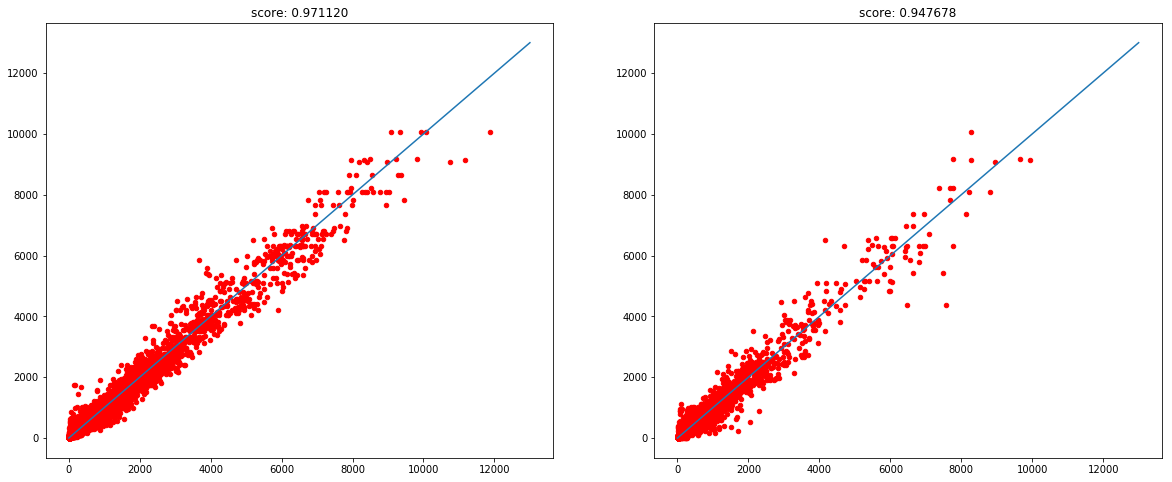

RMSE: 208.24483337827357


In [5]:
from sklearn import tree
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn import ensemble
from sklearn.tree import ExtraTreeRegressor
model = tree.DecisionTreeRegressor() # 决策树
# model = linear_model.LinearRegression() #线性回归
# model = svm.SVR() # SVM
# model = neighbors.KNeighborsRegressor() # KNN
# model = ensemble.RandomForestRegressor(n_estimators=20) # 使用20个决策树的rf
# model = ensemble.AdaBoostRegressor(n_estimators=50) # 使用50个决策树的adaboost
# model = ensemble.GradientBoostingRegressor(n_estimators=200) # 这里使用100个决策树的GBRT
# model_BaggingRegressor = ensemble.BaggingRegressor() #Bagging
# model = ExtraTreeRegressor() # 极端随机树
fit_and_perform(model, train_feats, train_labs, val_feats, val_labs)

In [7]:
len(val_labs)/2

2763.0

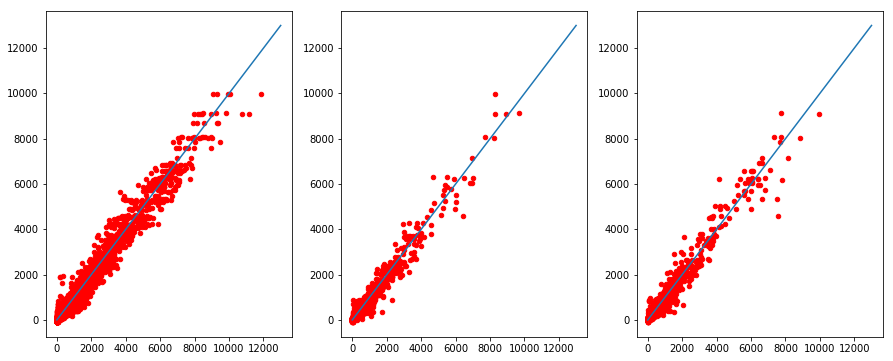

RMSE: 194.88732041578263


In [10]:
import xgboost as xgb
param = {'bst:max_depth':6, 'bst:eta':0.1, 'silent':1, 'objective':'reg:linear' }
plst = param.items()
num_round = 200
# param['nthread'] = 4
# plst += [('eval_metric', 'auc')] # Multiple evals can be handled in this way
# plst += [('eval_metric', 'ams@0')]

dtrain = xgb.DMatrix(train_feats, label=train_labs)
model = xgb.train(plst, dtrain, num_round)
dtest = xgb.DMatrix(train_feats)
train_res = model.predict(dtest)
dtest = xgb.DMatrix(val_feats)
val_res = model.predict(dtest)
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.scatter(train_labs,train_res, color = 'r', s = 20)
plt.plot([0, 13000],[0, 13000])
plt.subplot(122)
plt.scatter(val_labs, val_res, color = 'r', s = 20)
plt.plot([0, 13000],[0, 13000])
plt.show()
print("RMSE:",np.mean((val_res-val_labs)**2)**0.5)z

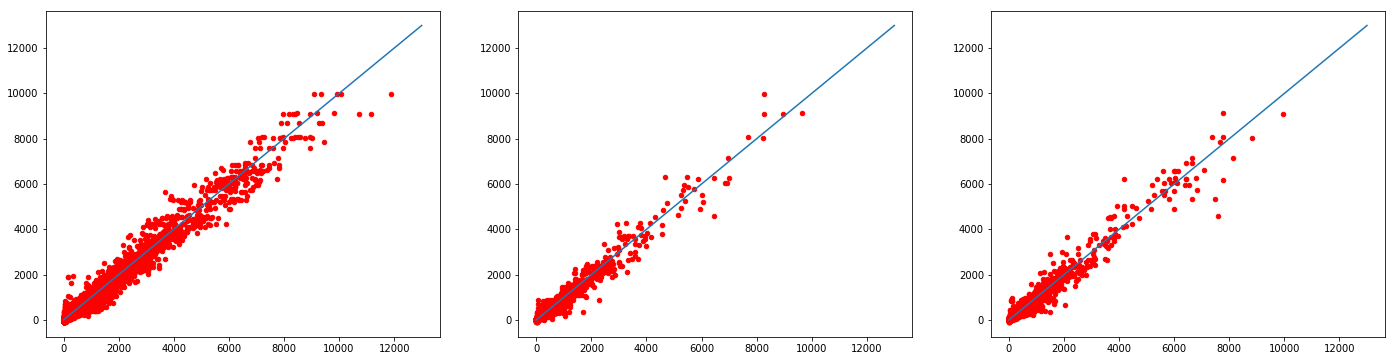

RMSE: 194.88732041578263


In [14]:
plt.figure(figsize=(24,6))
plt.subplot(131)
plt.scatter(train_labs,train_res, color = 'r', s = 20)
plt.plot([0, 13000],[0, 13000])
plt.subplot(132)
plt.scatter(val_labs[:2763], val_res[:2763], color = 'r', s = 20)
plt.plot([0, 13000],[0, 13000])
plt.subplot(133)
plt.scatter(val_labs[2763:], val_res[2763:], color = 'r', s = 20)
plt.plot([0, 13000],[0, 13000])
plt.show()
print("RMSE:",np.mean((val_res-val_labs)**2)**0.5)

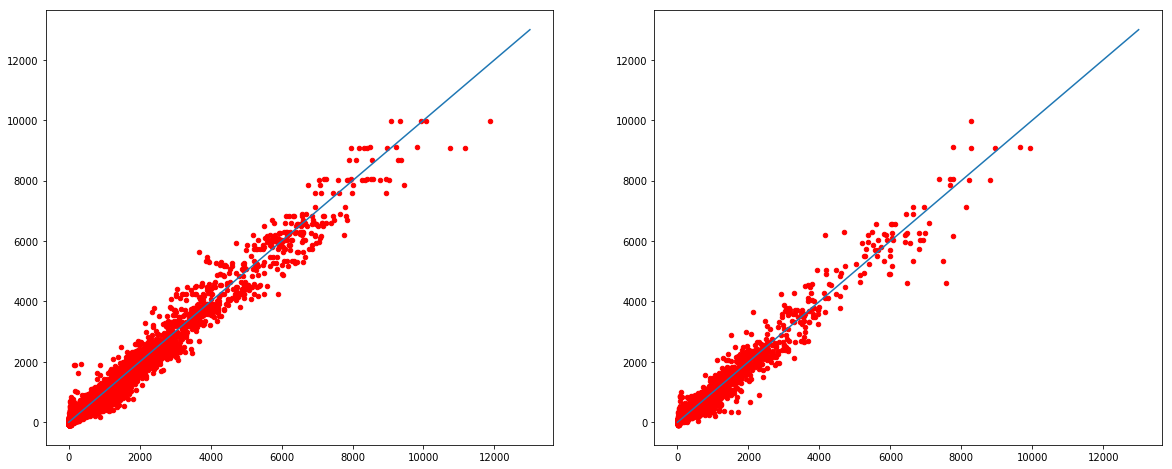

RMSE: 194.88732041578263


In [6]:
plt.figure(figsize=(20,8))
plt.subplot(121)
plt.scatter(train_labs,train_res, color = 'r', s = 20)
plt.plot([0, 13000],[0, 13000])
plt.subplot(122)
plt.scatter(val_labs, val_res, color = 'r', s = 20)
plt.plot([0, 13000],[0, 13000])
plt.show()
print("RMSE:",np.mean((val_res-val_labs)**2)**0.5)

| model | train score | val score | rmse
| - | - | - |- |
| dt | 0.9711 | 0.9476 | 208.2449 |
| lr | 0.5638 | 0.5777 | 591.6526 |
| rf(20) | 0.9706 | 0.9478 | 207.9079 |
| rf(200) | 0.9710 | 0.9489 | 205.6392 |
| AdaBoost | 0.2360 | 0.2671 | 779.3855 |
| GBRT | 0.7732 | 0.7913 | 415.8959 |
| et | 0.9711 | 0.9477 | 208.2448 |
| xgb | - | - | 194.8873 |

## 生成提交数据

In [ ]:
import json
import datetime
from sklearn import preprocessing
import numpy as np
fid = open("data/trains.json")
data_raw = json.load(fid)
fid.close()
start_time = datetime.datetime.strptime("2017-10-17", "%Y-%m-%d")
feats_raw = []
labs = []
for data in data_raw:
    data_time = datetime.datetime.strptime(data["date"], "%Y-%m-%d:%H")
    if data_time > start_time:
        holiday = int(data_time.weekday() == 5 or data_time.weekday() == 6)
        feats_raw.append([holiday, data_time.weekday(), data_time.hour, data["place"]-1])
        labs.append(data["people"])
ohcoder = preprocessing.OneHotEncoder()
ohcoder.fit(feats_raw)
print("code len:",ohcoder.n_values_)
feats = ohcoder.transform(feats_raw).toarray()

import xgboost as xgb
param = {'bst:max_depth':6, 'bst:eta':0.1, 'silent':1, 'objective':'reg:linear' }
plst = param.items()
num_round = 200

dtrain = xgb.DMatrix(feats, label=labs)
model = xgb.train(plst, dtrain, num_round)

def gen_times(begin_date, end_date):
    delta_time = datetime.timedelta(hours=1)
    while begin_date < end_date:
        yield begin_date
        begin_date = begin_date + delta_time
        
file_name = "result/result_2018-05-27.csv"
fid = open(file_name, 'w', encoding='utf8')
begin_date = datetime.datetime.strptime("2017-12-01", "%Y-%m-%d")
end_date = datetime.datetime.strptime("2018-01-01", "%Y-%m-%d")
for loc in range(1,34):
    for time in gen_times(begin_date, end_date):
        feat_raw = np.array([int(time.weekday() == 5 or time.weekday() == 6), time.weekday(), time.hour, loc-1])
        feat = ohcoder.transform(feat_raw.reshape(1,4)).toarray()
        dtest = xgb.DMatrix(feat)
        res = model.predict(dtest)
        tmp = [str(loc),datetime.datetime.strftime(time, "%Y-%m-%d %H"), str(max(res[0],0))+"\n"]
        fid.write(",".join(tmp))
fid.close()

## trick

In [108]:
# mul k
file_name = "data/combine1.csv"
R0 = 1045.2566
R1 = 204.2724

fid = open(file_name,"r")
line = fid.readlines()
fid.close()

C2 = 0
n = 9
for l in line:
    C2 += float(l.strip("\n").split(",")[-1])**2
    n += 1
k = n*(R0**2 - R1**2)/(2*C2) + 0.5

file_name_plus1 = file_name.split(".")
file_name_plus1[-2] = file_name_plus1[-2] + "+1"

fid = open(".".join(file_name_plus1),'w',encoding='utf8')
for l in line:
    tmp = l.strip("\n").split(",")[:-1]
    tmp.append(str(k*float(l.strip("\n").split(",")[-1]))+"\n")
    fid.write(",".join(tmp))
fid.close()

In [109]:
k

1.001148261051781

In [100]:
file_name = "data/result_2018-05-27-214.6804.csv"
R0 = 1045.2566
R1 = 214.6804

fid = open(file_name,"r")
line = fid.readlines()
fid.close()

C2 = 0
n = 9
for l in line:
    C2 += float(l.strip("\n").split(",")[-1])**2
    n += 1
k = n*(R0**2 - R1**2)/(2*C2) + 0.5

file_name_plus1 = file_name.split(".")
file_name_plus1[-2] = file_name_plus1[-2] + "+1"

fid = open(".".join(file_name_plus1),'w',encoding='utf8')
for l in line:
    tmp = l.strip("\n").split(",")[:-1]
    tmp.append(str(k*float(l.strip("\n").split(",")[-1]))+"\n")
    fid.write(",".join(tmp))
fid.close()

In [107]:
# bagging
file_name1 = "data/result_2018-05-26-214.1222+1.csv"
file_name2 = "data/result_2018-05-27-214.6804+1.csv"
fid = open(file_name1,"r")
line1 = fid.readlines()
fid.close()
fid = open(file_name2,"r")
line2 = fid.readlines()
fid.close()

n = len(line1)
fid = open("data/combine1.csv", 'w',encoding='utf8')
for i in range(n):
    tmp = line1[i].strip("\n").split(",")[:-1]
    res = (float(line1[i].strip("\n").split(",")[-1]) + float(line2[i].strip("\n").split(",")[-1]))/2
    tmp.append(str(res)+"\n")
    fid.write(",".join(tmp))
fid.close()